# Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Raw data

In [3]:
CSV_FILE_PATH = "../data/preprocessed_data.csv"
MAX_RSSI = 0
MIN_RSSI = -99
DENOISE_SNR = 20

df = pd.read_csv(CSV_FILE_PATH)
df.head()

,tag,x,y,z,timestamp,0,-1,-2,-3,-4,...,-90,-91,-92,-93,-94,-95,-96,-97,-98,-99
0,BP_WirelessTransmitter_C_UAID_3814280578B89E1D...,0.0,0.0,0.000000,1656943851933,0,0,0,0,0,...,298,298,319,333,317,349,335,353,358,363
1,BP_WirelessTransmitter_C_UAID_3814280578B8E71C...,1210.0,1150.0,162.012604,1656943852027,0,1,0,0,0,...,1531,1667,1843,2029,2216,2347,2408,2701,2947,3199
2,BP_WirelessTransmitter_C_UAID_3814280578B8B91A...,1210.0,1150.0,162.012604,1656943852084,0,0,0,0,0,...,1163,1331,1574,1728,1802,1919,2155,2476,2776,3116
3,Total,1210.0,1150.0,162.012604,1656943852133,2,0,0,0,0,...,1963,2097,2178,2390,2663,3060,3561,3989,4235,5014
4,BP_WirelessTransmitter_C_UAID_3814280578B89E1D...,1210.0,1150.0,162.012604,1656943852166,0,0,0,0,0,...,1518,1595,1822,1917,2164,2354,2496,2837,3218,3520


### WindowSplitter - split data as time serise

In [4]:
class WindowSplitter:
    """
        Window splitter Given a time series data set, the splitter
        can split it based on window size, feature columns
    """
    def __init__(self, input_width, label_width, shift, columns, input_columns=None, label_columns=None):
        """
        :param input_width: input window size
        :param label_width: label(output) window size
        :param shift: control offset between input and output on time axis
        :param columns: all feature column names
        :param input_columns: input column names
        :param label_columns: label column names
        """
        self.input_width, self.label_width = input_width, label_width
        self.shift = shift
        self.columns = columns
        self.input_columns, self.label_columns = input_columns, label_columns
        # the total window size
        self.total_window_size = input_width + shift
        # init column index
        self.init_columns_indices()

    def init_columns_indices(self):
        # all column index
        self.column_indices = {name: i for i, name in enumerate(self.columns)}
        # input columns indices
        self.input_slice = slice(0, self.input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        if self.input_columns is not None:
            self.input_columns_indices = {name: i for i, name in enumerate(self.input_columns)}
        # label columns indices
        self.label_slice = slice(self.total_window_size - self.label_width, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
        if self.label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(self.label_columns)}

    def __call__(self, data):
        """
        :param data: shape(batch_size，seq_len, feature_dim)
        :return inputs: input series
        :return labels: output series
        """
        # 1.
        inputs, labels = data[:, self.input_slice, :], data[:, self.label_slice, :]
        # 2.
        if self.input_columns is not None:
            inputs = tf.stack([inputs[:, :, self.column_indices[name]] for name in self.input_columns], axis=-1)
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        # 3.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

### DatasetGenerate - generate time serise dataset

In [5]:
class DatasetGenerator(WindowSplitter):
    """
        Dataset Generator - generate time serise dataset
    """
    def __init__(self, data, input_width, label_width, shift,
                 columns, input_columns, label_columns, batch_size,
                 partition=(0.7, 0.2, 0.1), dtype='float32'):
        """
        :param data: the data before split，shape(seq_len, dim)
        :param input_width: input window size (input series size)
        :param label_width: label window size (label series size)
        :param shift: offset
        :param columns: list of column name
        :param input_columns: list of input feature column names
        :param label_columns: list of label feature column names
        :param batch_size: batch size
        :param partition: proportion of training/validation/testing dataset
        """
        super().__init__(input_width=input_width, label_width=label_width, shift=shift,
                         columns=columns, input_columns=input_columns, label_columns=label_columns)
        self.batch_size = batch_size
        self.partition = partition

        data = data.to_numpy().astype(dtype)
        seq_len = data.shape[0]
        self.train_width, self.val_width, self.test_width = [int(seq_len * p) for p in self.partition]
        train = data[:self.train_width]
        valid = data[self.train_width:self.train_width + self.val_width]
        test = data[self.train_width + self.val_width:]

        self.train_ds = self.build_dataset(train)
        self.valid_ds = self.build_dataset(valid)
        self.test_ds = self.build_dataset(test)

    def build_dataset(self, data):
        """ Construct Dataset, split input data to training set/ validation set and test set

        Algorithm：
            1. call tensorflow api with batch_size=1 as the first time construct
            2. use map function，split each data point from dataset to input/label series
            3. then re-batch data set to desired size

        :param data: shape(seq_len, feature_dim)
        :return: batched dataset
        """
        # 1.
        dataset = timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size,
                                                sequence_stride=1, shuffle=True, batch_size=1)
        # 2.
        dataset = dataset.map(self)
        # 3.
        return dataset.unbatch().batch(self.batch_size)

    def __repr__(self):
        return '\n'.join([
            f'<DatasetGenerator>',
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Input column name(s): {self.input_columns}',
            f'Label column name(s): {self.label_columns}',
            f'Batch size: {self.batch_size}',
            f'Partition: Train(%.2f), Validation(%.2f), Test(%.2f)' % self.partition,
        ])

### Dataset contains measurement from only one transmitter

In [6]:
df.tag.unique()

array(['BP_WirelessTransmitter_C_UAID_3814280578B89E1D01_1324636591',
       'BP_WirelessTransmitter_C_UAID_3814280578B8E71C01_1259575383',
       'BP_WirelessTransmitter_C_UAID_3814280578B8B91A01_1331298178',
       'Total', 'BP_WirelessTransmitter_C_1'], dtype=object)

In [9]:
df_tx = df[df.tag == 'BP_WirelessTransmitter_C_1'][1:].reset_index(drop=True)
df_tx

,tag,x,y,z,timestamp,0,-1,-2,-3,-4,...,-90,-91,-92,-93,-94,-95,-96,-97,-98,-99
0,BP_WirelessTransmitter_C_1,-50.000000,-50.000000,50.000000,1656990187757,1948,0,0,0,261,...,2992,3382,3935,4723,5379,6701,7747,8410,9476,10575
1,BP_WirelessTransmitter_C_1,-50.000000,-50.000000,50.000000,1656990187823,1948,0,0,0,277,...,2867,3475,3964,4674,5390,6702,7783,8371,9427,10537
2,BP_WirelessTransmitter_C_1,-50.000000,-50.000000,50.000000,1656990187887,1948,0,0,0,251,...,3040,3378,4062,4635,5368,6631,7747,8434,9402,10625
3,BP_WirelessTransmitter_C_1,-50.000000,-50.000000,50.000000,1656990187950,1948,0,0,0,277,...,2932,3501,3920,4703,5311,6786,7718,8433,9458,10454
4,BP_WirelessTransmitter_C_1,-50.000000,-50.000000,50.000000,1656990188014,1948,0,0,0,257,...,2919,3488,3870,4671,5382,6777,7658,8338,9586,10503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2448,BP_WirelessTransmitter_C_1,-612.435974,518.061401,106.502289,1656990341345,0,0,0,0,0,...,39,45,53,47,56,65,86,70,89,108
2449,BP_WirelessTransmitter_C_1,-574.059265,584.403381,106.502289,1656990341408,0,0,0,0,0,...,47,38,44,67,83,61,83,93,96,117
2450,BP_WirelessTransmitter_C_1,-547.092224,629.183044,106.502289,1656990341472,0,0,0,0,0,...,38,39,48,64,64,84,74,96,97,116
2451,BP_WirelessTransmitter_C_1,-537.058594,645.844299,106.502289,1656990341536,0,0,0,0,0,...,44,40,46,64,56,86,74,85,113,121


#### Seperate input and label for preprocessing

In [10]:
raw_df = df_tx.drop(columns=['tag', 'timestamp'])
input_df = raw_df.loc[:,f"{MAX_RSSI}":f"{MIN_RSSI}"].astype('float')
label_df = raw_df[['x','y','z']]

#### Convert the sample count to probability distribution

In [11]:
input_df = input_df.loc[:,f"{MAX_RSSI}":f"{MIN_RSSI}"].div(input_df.sum(axis=1), axis=0)
input_df.head()

,0,-1,-2,-3,-4,-5,-6,-7,-8,-9,...,-90,-91,-92,-93,-94,-95,-96,-97,-98,-99
0,0.021821,0.0,0.0,0.0,0.002924,0.002498,0.000123,0.000022,0.000011,0.000000,...,0.033516,0.037885,0.044079,0.052906,0.060255,0.075064,0.086781,0.094208,0.106149,0.118460
1,0.021849,0.0,0.0,0.0,0.003107,0.002580,0.000090,0.000011,0.000000,0.000011,...,0.032156,0.038975,0.044460,0.052423,0.060454,0.075169,0.087293,0.093888,0.105732,0.118182
2,0.021841,0.0,0.0,0.0,0.002814,0.002680,0.000112,0.000011,0.000000,0.000011,...,0.034085,0.037875,0.045544,0.051968,0.060187,0.074348,0.086860,0.094563,0.105417,0.119129
3,0.021856,0.0,0.0,0.0,0.003108,0.002524,0.000090,0.000011,0.000000,0.000000,...,0.032897,0.039281,0.043982,0.052767,0.059589,0.076139,0.086596,0.094618,0.106118,0.117293
4,0.021841,0.0,0.0,0.0,0.002881,0.002523,0.000090,0.000000,0.000000,0.000000,...,0.032728,0.039108,0.043391,0.052371,0.060343,0.075984,0.085862,0.093486,0.107478,0.117760


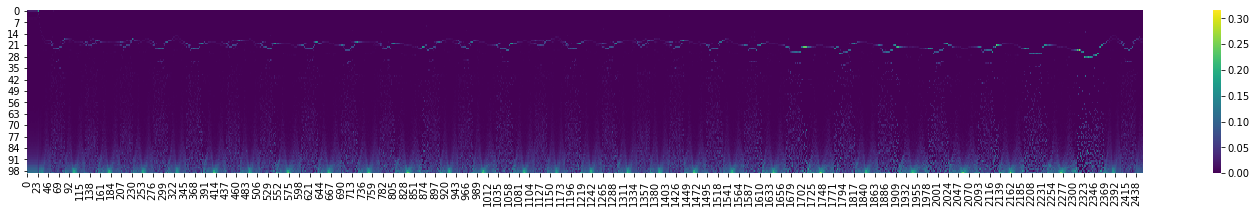

In [12]:
plt.figure(figsize=(25,3))
ax = sns.heatmap(input_df.to_numpy().transpose(1,0),cmap="viridis")
plt.show()

#### Concat label with input

In [13]:
new_df = pd.concat([label_df, input_df], axis=1)
new_df.head()

,x,y,z,0,-1,-2,-3,-4,-5,-6,...,-90,-91,-92,-93,-94,-95,-96,-97,-98,-99
0,-50.0,-50.0,50.0,0.021821,0.0,0.0,0.0,0.002924,0.002498,0.000123,...,0.033516,0.037885,0.044079,0.052906,0.060255,0.075064,0.086781,0.094208,0.106149,0.118460
1,-50.0,-50.0,50.0,0.021849,0.0,0.0,0.0,0.003107,0.002580,0.000090,...,0.032156,0.038975,0.044460,0.052423,0.060454,0.075169,0.087293,0.093888,0.105732,0.118182
2,-50.0,-50.0,50.0,0.021841,0.0,0.0,0.0,0.002814,0.002680,0.000112,...,0.034085,0.037875,0.045544,0.051968,0.060187,0.074348,0.086860,0.094563,0.105417,0.119129
3,-50.0,-50.0,50.0,0.021856,0.0,0.0,0.0,0.003108,0.002524,0.000090,...,0.032897,0.039281,0.043982,0.052767,0.059589,0.076139,0.086596,0.094618,0.106118,0.117293
4,-50.0,-50.0,50.0,0.021841,0.0,0.0,0.0,0.002881,0.002523,0.000090,...,0.032728,0.039108,0.043391,0.052371,0.060343,0.075984,0.085862,0.093486,0.107478,0.117760


#### Get the different between each row

In [14]:
diff_df = new_df.diff(axis=0)[1:]
diff_df.head()

,x,y,z,0,-1,-2,-3,-4,-5,-6,...,-90,-91,-92,-93,-94,-95,-96,-97,-98,-99
1,0.0,0.0,0.0,0.000027,0.000000,0.0,0.0,0.000183,0.000082,-3.349297e-05,...,-0.001360,0.001091,0.000381,-0.000483,0.000199,0.000106,0.000513,-0.000319,-0.000416,-0.000277
2,0.0,0.0,0.0,-0.000007,0.000000,0.0,0.0,-0.000293,0.000100,2.239411e-05,...,0.001929,-0.001101,0.001084,-0.000455,-0.000267,-0.000821,-0.000433,0.000675,-0.000316,0.000947
3,0.0,0.0,0.0,0.000015,0.000000,0.0,0.0,0.000294,-0.000155,-2.236189e-05,...,-0.001188,0.001406,-0.001562,0.000799,-0.000598,0.001791,-0.000265,0.000055,0.000702,-0.001836
4,0.0,0.0,0.0,-0.000015,0.000000,0.0,0.0,-0.000226,-0.000002,-6.340231e-08,...,-0.000169,-0.000174,-0.000592,-0.000396,0.000754,-0.000155,-0.000734,-0.001132,0.001360,0.000467
5,0.0,0.0,0.0,0.000010,0.000011,0.0,0.0,0.000091,0.000035,2.247560e-05,...,0.001025,-0.001171,0.002207,-0.000234,-0.000690,-0.000963,-0.000297,0.001535,-0.000882,-0.000406


#### normalize the diff

In [15]:
norm_df = (diff_df-diff_df.mean())/(diff_df.std() + 1e-10)
norm_df.head()

,x,y,z,0,-1,-2,-3,-4,-5,-6,...,-90,-91,-92,-93,-94,-95,-96,-97,-98,-99
1,0.00374,-0.005377,-0.060256,0.009352,0.00000,0.0,1.060820e-18,0.577345,0.221969,-0.392409,...,-0.071592,0.052720,0.017516,-0.020761,0.008785,0.004363,0.020116,-0.011299,-0.014470,-0.008490
2,0.00374,-0.005377,-0.060256,0.000399,0.00000,0.0,1.060820e-18,-0.912655,0.271353,0.263357,...,0.101252,-0.053021,0.049649,-0.019543,-0.011795,-0.033335,-0.016593,0.025023,-0.010899,0.030293
3,0.00374,-0.005377,-0.060256,0.006205,0.00000,0.0,1.060820e-18,0.923618,-0.414026,-0.261800,...,-0.062561,0.067955,-0.071234,0.034622,-0.026396,0.072907,-0.010071,0.002356,0.025306,-0.057855
4,0.00374,-0.005377,-0.060256,-0.001684,0.00000,0.0,1.060820e-18,-0.705531,-0.002053,-0.000154,...,-0.009004,-0.008281,-0.026914,-0.017001,0.033287,-0.006220,-0.028271,-0.041008,0.048737,0.015076
5,0.00374,-0.005377,-0.060256,0.004879,0.35682,0.0,1.060820e-18,0.288971,0.096207,0.264313,...,0.053727,-0.056415,0.100987,-0.009997,-0.030479,-0.039111,-0.011315,0.056457,-0.031028,-0.012556


In [22]:
columns = list(norm_df)

dataset_generator = DatasetGenerator(data=norm_df,
                                     input_width=30,
                                     label_width=30,
                                     shift=1,
                                     columns=list(norm_df),
                                     input_columns=columns[3:],
                                     label_columns=columns[:3],
                                     batch_size=16,
                                     partition=(0.8, 0.1, 0.1))

In [23]:
print(dataset_generator)

<DatasetGenerator>
Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Input column name(s): ['0', '-1', '-2', '-3', '-4', '-5', '-6', '-7', '-8', '-9', '-10', '-11', '-12', '-13', '-14', '-15', '-16', '-17', '-18', '-19', '-20', '-21', '-22', '-23', '-24', '-25', '-26', '-27', '-28', '-29', '-30', '-31', '-32', '-33', '-34', '-35', '-36', '-37', '-38', '-39', '-40', '-41', '-42', '-43', '-44', '-45', '-46', '-47', '-48', '-49', '-50', '-51', '-52', '-53', '-54', '-55', '-56', '-57', '-58', '-59', '-60', '-61', '-62', '-63', '-64', '-65', '-66', '-67', '-68', '-69', '-70', '-71', '-72', '-73', '-74', '-75', '-76', '-77', '-78', '-79', '-80', '-81', '-82', '-83', '-84', '-85', '-86', '-87', '-88', '-89', '-90', '-91', '-92', '-93', '-94', '-95', '-96', '-97', '-98', '-99']
Label column name(s): ['x', 'y'

### Try on Model

In [24]:
from nn.deepar import create_model
import time

In [25]:
model = create_model(dim_x=len(columns) - 3, dim_z=3)

In [26]:
EPOCHS = 100
train_result, test_result = {}, {}
train_ds = dataset_generator.train_ds
test_ds = dataset_generator.test_ds
for i in range(EPOCHS):
    start = time.time()
    for data in train_ds:
        train_result = model.train_step(data)
    
    for data in test_ds:
        test_result = model.test_step(data)
    template = 'Epoch {}, Loss: {:.5f}, RMSE {:.5f}, Test Loss: {:.5f}, Test RMSE {:.5f}, ETC {:.5f} secs'
    print(template.format(i + 1,train_result['loss'], train_result['rmse'],test_result['loss'], test_result['rmse'],time.time() - start))

Epoch 1, Loss: 4.97656, RMSE 0.73335, Test Loss: 7.89038, Test RMSE 0.71980, ETC 16.05983 secs
Epoch 2, Loss: 4.19349, RMSE 0.67127, Test Loss: 9.96633, Test RMSE 0.66809, ETC 15.23749 secs
Epoch 3, Loss: 4.17967, RMSE 0.64628, Test Loss: 14.60639, Test RMSE 0.64443, ETC 15.32830 secs
Epoch 4, Loss: 4.03013, RMSE 0.63170, Test Loss: 20.21711, Test RMSE 0.63066, ETC 16.00470 secs
Epoch 5, Loss: 3.85787, RMSE 0.62199, Test Loss: 42.01247, Test RMSE 0.62150, ETC 15.85871 secs
Epoch 6, Loss: 3.85015, RMSE 0.61531, Test Loss: 31.94325, Test RMSE 0.61493, ETC 15.58591 secs
Epoch 7, Loss: 3.66333, RMSE 0.61019, Test Loss: 49.24549, Test RMSE 0.60997, ETC 16.46518 secs
Epoch 8, Loss: 3.67992, RMSE 0.60648, Test Loss: 48.99429, Test RMSE 0.60639, ETC 15.72488 secs
Epoch 9, Loss: 3.56841, RMSE 0.60322, Test Loss: 88.96109, Test RMSE 0.60319, ETC 15.94663 secs
Epoch 10, Loss: 3.49545, RMSE 0.60070, Test Loss: 105.44814, Test RMSE 0.60069, ETC 15.98700 secs
Epoch 11, Loss: 3.56414, RMSE 0.59862, T

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\zhong\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-0efa75c02c65>", line 8, in <module>
    train_result = model.train_step(data)
  File "C:\Users\zhong\Documents\Unreal Projects\WiTracingSim\Source\WiTracingPy\nn\deepar\__init__.py", line 81, in train_step
    μ, σ = self(inputs=inp, training=True)
  File "c:\users\zhong\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1030, in __call__
    outputs = call_fn(inputs, *args, **kwargs)
  File "C:\Users\zhong\Documents\Unreal Projects\WiTracingSim\Source\WiTracingPy\nn\deepar\__init__.py", line 63, in call
    x = inputs[:, n, :]
  File "c:\users\zhong\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\util\dispatch.py", line 206, in wrapper
    return target

TypeError: object of type 'NoneType' has no len()

In [27]:
import IPython
import IPython.display

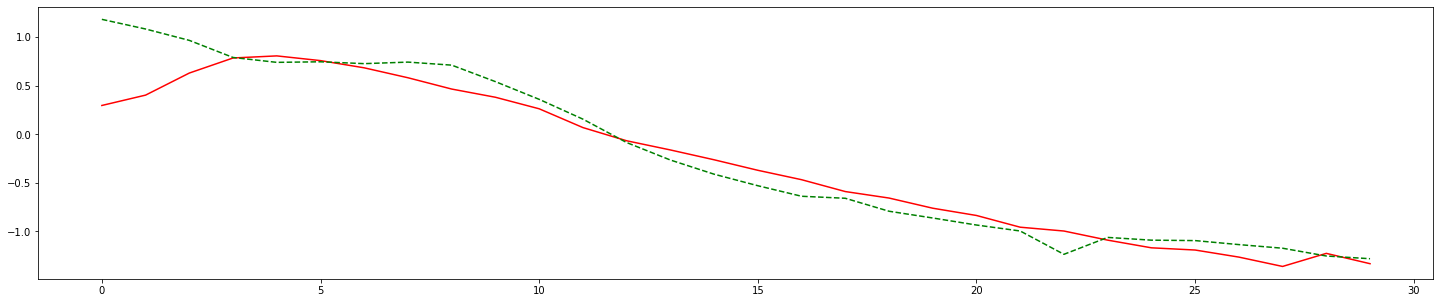

In [81]:
plt.figure(figsize=(25,5))
example = next(iter( dataset_generator.train_ds))
result = model(example[0])
plt.plot(result[0][0,:,1], 'r')
plt.plot(example[1][0,:,1], 'g--')

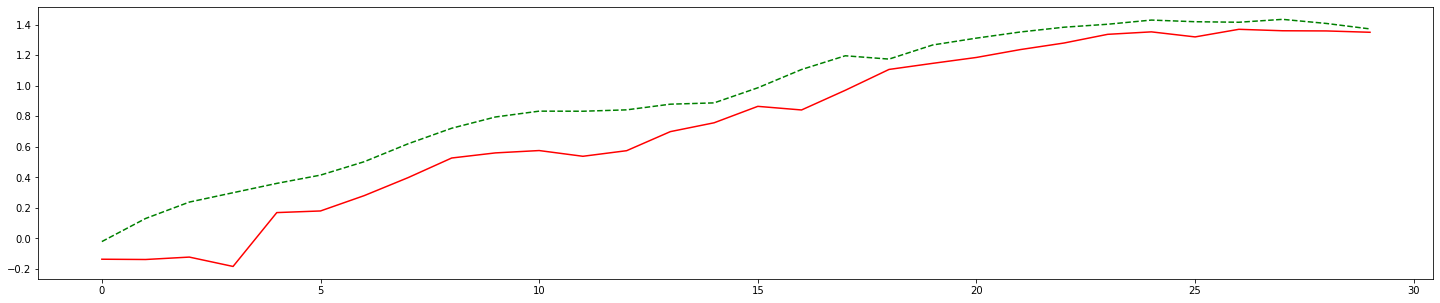

In [87]:
plt.figure(figsize=(25,5))
example = next(iter( dataset_generator.test_ds))
result = model(example[0])
plt.plot(result[0][0,:,0],'r')
plt.plot(example[1][0,:,0], 'g--')

In [ ]:
def 

In [134]:
def plot(datagen, example, model, plot_col, max_subplots=3):
    inputs, labels = example
    plt.figure(figsize=(12, 8))
        
    plot_col_index = datagen.column_indices[plot_col]

    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
#         plt.plot(datagen.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if datagen.label_columns:
            label_col_index = datagen.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(datagen.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            mu, sigma = predictions[0][n, :, label_col_index], predictions[1][n, :, label_col_index]
            plt.scatter(datagen.label_indices, mu, marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)
        
            plt.fill_between(datagen.label_indices, (mu-3*sigma),(mu+3*sigma), color='b', alpha=.1)
        if n == 0:
            plt.legend()
        
        plt.xlabel('Time [h]')

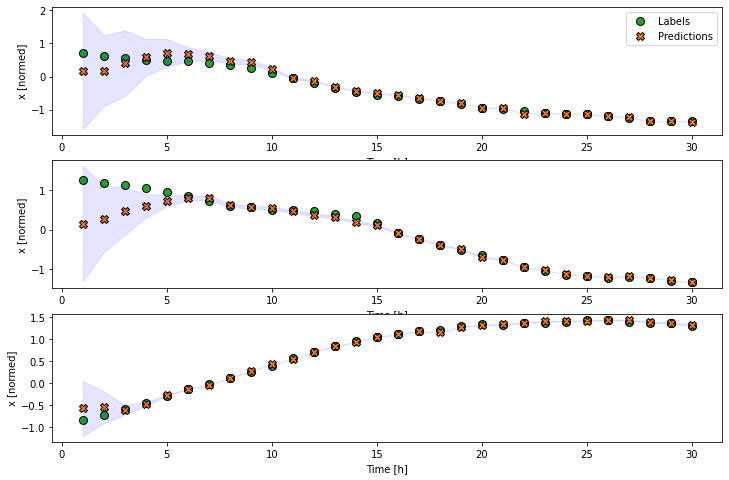

In [135]:
example = next(iter( dataset_generator.train_ds))
plot(dataset_generator, example,  model, 'x')

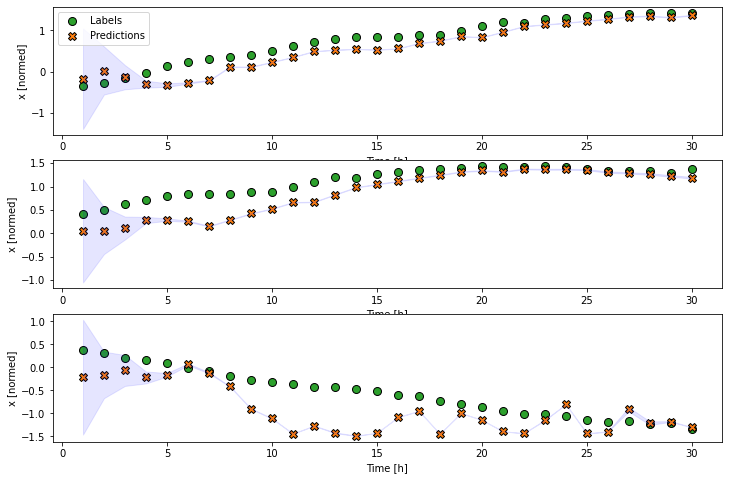

In [136]:
example = next(iter( dataset_generator.test_ds))
plot(dataset_generator, example,  model, 'x')